In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from matplotlib.legend_handler import HandlerPathCollection
import warnings
warnings.filterwarnings('ignore')

print("Librerías cargadas")

Librerías cargadas


In [2]:
# Cargar datos
df_train = pd.read_csv("../../data/data/application_train.csv")

print(f"Datos cargados: {df_train.shape[0]:,} registros, {df_train.shape[1]} columnas")
print(f"Tasa de fraude: {df_train['TARGET'].mean()*100:.2f}%")

Datos cargados: 307,511 registros, 122 columnas
Tasa de fraude: 8.07%


In [3]:
# Seleccionar columnas numéricas
columnas_numericas = df_train.select_dtypes(include=[np.number]).columns.tolist()
if 'SK_ID_CURR' in columnas_numericas:
    columnas_numericas.remove('SK_ID_CURR')

# Seleccionar columnas categóricas importantes
columnas_categoricas = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'
]

print(f"Variables numéricas: {len(columnas_numericas)}")
print(f"Variables categóricas: {len(columnas_categoricas)}")

Variables numéricas: 105
Variables categóricas: 15


In [4]:
# Preparar dataset numérico
df_numerico = df_train[columnas_numericas].copy()
df_numerico = df_numerico.fillna(df_numerico.median())

print(f"Dataset numérico: {df_numerico.shape}")

Dataset numérico: (307511, 105)


In [5]:
# Aplicar Label Encoding a variables categóricas
print("Aplicando Label Encoding...")

df_categoricas = pd.DataFrame()
label_encoders = {}

for col in columnas_categoricas:
    if col in df_train.columns:
        le = LabelEncoder()
        # Rellenar nulos con 'Missing'
        valores = df_train[col].fillna('Missing').astype(str)
        df_categoricas[col] = le.fit_transform(valores)
        label_encoders[col] = le
        print(f"  {col}: {len(le.classes_)} categorías")

print(f"\nDataset categórico: {df_categoricas.shape}")

Aplicando Label Encoding...
  NAME_CONTRACT_TYPE: 2 categorías
  CODE_GENDER: 3 categorías
  FLAG_OWN_CAR: 2 categorías
  FLAG_OWN_REALTY: 2 categorías
  NAME_TYPE_SUITE: 8 categorías
  NAME_INCOME_TYPE: 8 categorías
  NAME_EDUCATION_TYPE: 5 categorías
  NAME_FAMILY_STATUS: 6 categorías
  NAME_HOUSING_TYPE: 6 categorías
  OCCUPATION_TYPE: 19 categorías
  WEEKDAY_APPR_PROCESS_START: 7 categorías
  ORGANIZATION_TYPE: 58 categorías
  FONDKAPREMONT_MODE: 5 categorías
  HOUSETYPE_MODE: 4 categorías
  WALLSMATERIAL_MODE: 8 categorías

Dataset categórico: (307511, 15)


In [6]:
# Combinar variables numéricas y categóricas
df_completo = pd.concat([df_numerico, df_categoricas], axis=1)

print(f"Dataset completo: {df_completo.shape}")
print(f"Total de features: {len(columnas_numericas)} numéricas + {len(df_categoricas.columns)} categóricas = {df_completo.shape[1]}")

Dataset completo: (307511, 120)
Total de features: 105 numéricas + 15 categóricas = 120


In [7]:
# Tomar muestra para eficiencia computacional
muestra_size = 10000
if len(df_completo) > muestra_size:
    df_lof = df_completo.sample(n=muestra_size, random_state=42)
    target_muestra = df_train.loc[df_lof.index, 'TARGET']
    print(f"Muestra: {muestra_size:,} registros")
else:
    df_lof = df_completo.copy()
    target_muestra = df_train['TARGET']
    print(f"Dataset completo: {len(df_lof):,} registros")

print(f"Tasa de fraude en muestra: {target_muestra.mean()*100:.2f}%")

Muestra: 10,000 registros
Tasa de fraude en muestra: 8.23%


In [8]:
# Aplicar Local Outlier Factor
print("Entrenando LOF...")

modelo_lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination='auto',
    n_jobs=-1
)

etiquetas = modelo_lof.fit_predict(df_lof)
scores = -modelo_lof.negative_outlier_factor_

print("Entrenamiento completado")

Entrenando LOF...
Entrenamiento completado


In [9]:
# Agregar resultados
df_lof['SCORE_LOF'] = scores
df_lof['PREDICCION'] = etiquetas
df_lof['ES_ANOMALIA'] = (etiquetas == -1).astype(int)
df_lof['TARGET'] = target_muestra.values

num_anomalias = df_lof['ES_ANOMALIA'].sum()
print(f"\nAnomalías detectadas: {num_anomalias:,} ({num_anomalias/len(df_lof)*100:.2f}%)")


Anomalías detectadas: 486 (4.86%)


In [10]:
# Calcular métricas con TARGET real
from sklearn.metrics import precision_score, recall_score, f1_score

# Normalizar scores a 0-1 para ROC-AUC
scores_norm = (scores - scores.min()) / (scores.max() - scores.min())

roc_auc = roc_auc_score(df_lof['TARGET'], scores_norm)
precision = precision_score(df_lof['TARGET'], df_lof['ES_ANOMALIA'], zero_division=0)
recall = recall_score(df_lof['TARGET'], df_lof['ES_ANOMALIA'], zero_division=0)
f1 = f1_score(df_lof['TARGET'], df_lof['ES_ANOMALIA'], zero_division=0)

print(f"\nMétricas:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(df_lof['TARGET'], df_lof['ES_ANOMALIA'], 
                           target_names=['Normal', 'Fraude'], zero_division=0))


Métricas:
ROC-AUC: 0.4868
Precision: 0.0823
Recall: 0.0486
F1-Score: 0.0611

Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       0.92      0.95      0.93      9177
      Fraude       0.08      0.05      0.06       823

    accuracy                           0.88     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.85      0.88      0.86     10000



Generando visualización t-SNE...


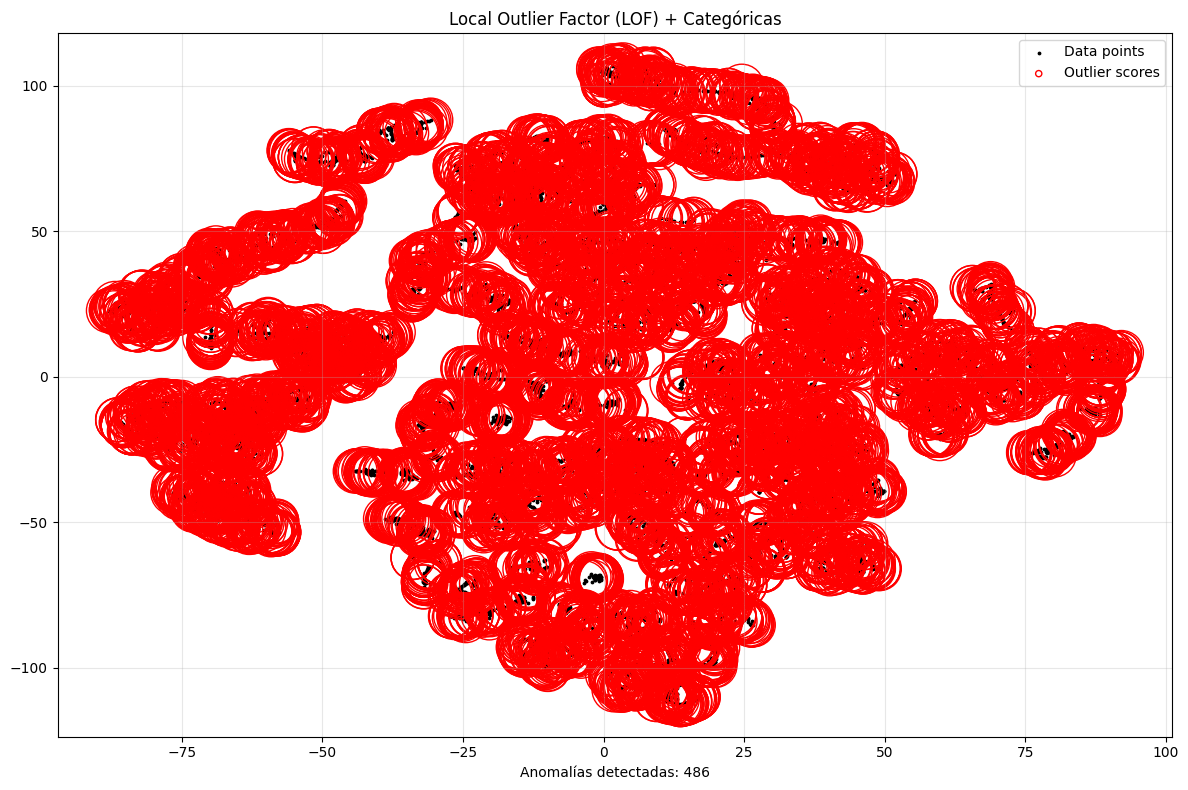

In [11]:
# Visualización con t-SNE
print("Generando visualización t-SNE...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
datos_2d = tsne.fit_transform(df_lof.drop(['SCORE_LOF', 'PREDICCION', 'ES_ANOMALIA', 'TARGET'], axis=1))

# Función para personalizar tamaño de marcador en leyenda
def update_legend_marker_size(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([20])

plt.figure(figsize=(12, 8))

# Graficar puntos de datos
plt.scatter(datos_2d[:, 0], datos_2d[:, 1], 
           color='k', s=3.0, label='Data points')

# Calcular radio proporcional a los scores
X_scores = df_lof['SCORE_LOF'].values
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

# Graficar círculos con radio proporcional
scatter = plt.scatter(
    datos_2d[:, 0],
    datos_2d[:, 1],
    s=1000 * radius,
    edgecolors='r',
    facecolors='none',
    label='Outlier scores'
)

plt.axis('tight')
plt.xlabel(f'Anomalías detectadas: {df_lof["ES_ANOMALIA"].sum()}')
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title('Local Outlier Factor (LOF) + Categóricas')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

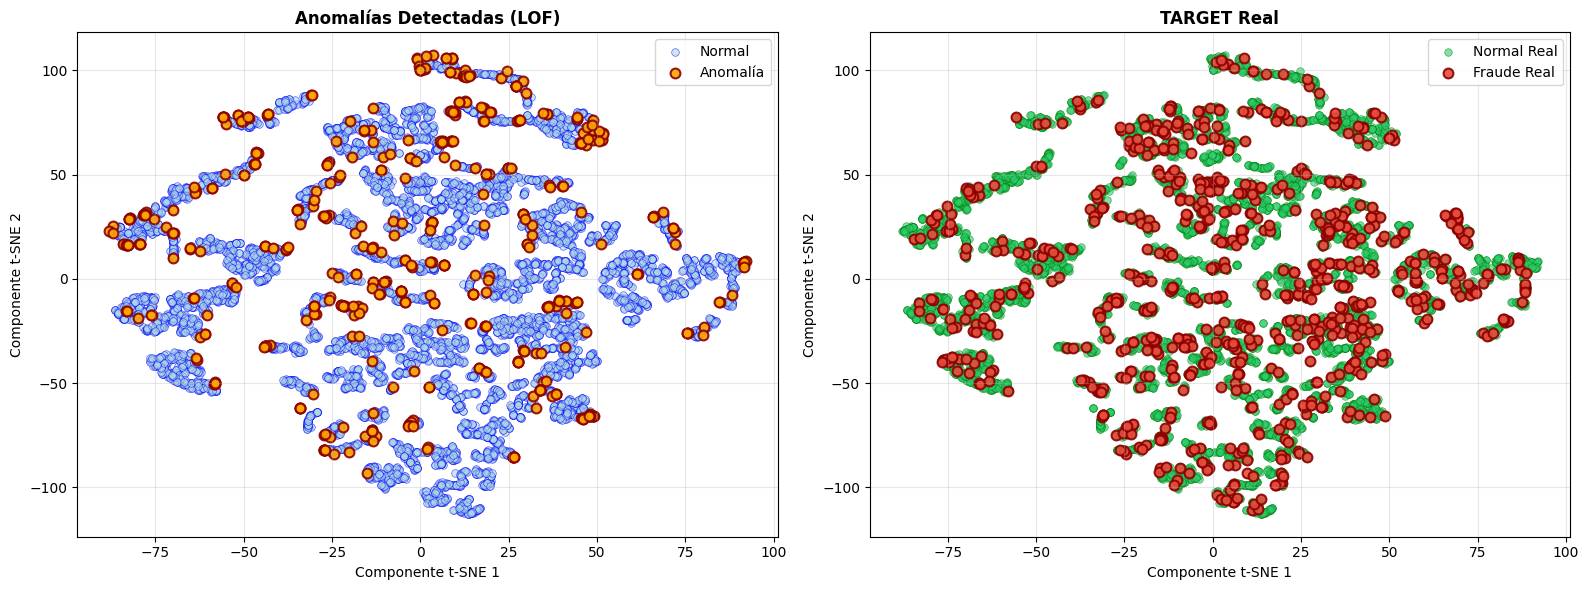

In [12]:
# Comparación: Predicción vs Real
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Anomalías detectadas
normales = df_lof['ES_ANOMALIA'] == 0
anomalias = df_lof['ES_ANOMALIA'] == 1

axes[0].scatter(datos_2d[normales, 0], datos_2d[normales, 1],
               c='lightblue', s=30, alpha=0.6, edgecolors='blue', 
               linewidth=0.5, label='Normal')
axes[0].scatter(datos_2d[anomalias, 0], datos_2d[anomalias, 1],
               c='orange', s=50, alpha=0.9, edgecolors='darkred', 
               linewidth=1.5, label='Anomalía')
axes[0].set_title('Anomalías Detectadas (LOF)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Componente t-SNE 1')
axes[0].set_ylabel('Componente t-SNE 2')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: TARGET real
normales_real = df_lof['TARGET'] == 0
fraudes_real = df_lof['TARGET'] == 1

axes[1].scatter(datos_2d[normales_real, 0], datos_2d[normales_real, 1],
               c='#2ecc71', s=30, alpha=0.6, edgecolors='green', 
               linewidth=0.5, label='Normal Real')
axes[1].scatter(datos_2d[fraudes_real, 0], datos_2d[fraudes_real, 1],
               c='#e74c3c', s=50, alpha=0.9, edgecolors='darkred', 
               linewidth=1.5, label='Fraude Real')
axes[1].set_title('TARGET Real', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

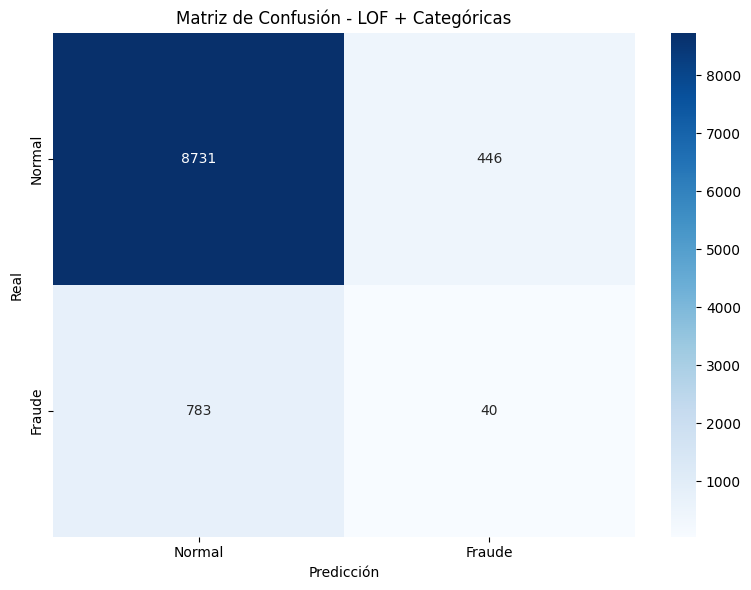

In [13]:
# Matriz de confusión
cm = confusion_matrix(df_lof['TARGET'], df_lof['ES_ANOMALIA'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - LOF + Categóricas')
plt.tight_layout()
plt.show()

In [14]:
# Top 10 casos con mayor score LOF
top_10 = df_lof.nlargest(10, 'SCORE_LOF')

print("\nTop 10 casos con mayor score LOF:\n")
for idx, (i, fila) in enumerate(top_10.iterrows(), 1):
    target_text = 'FRAUDE' if fila['TARGET'] == 1 else 'Normal'
    print(f"#{idx} | Score: {fila['SCORE_LOF']:.4f} | Real: {target_text}")

fraudes_reales = top_10['TARGET'].sum()
print(f"\nFraudes reales en Top 10: {fraudes_reales}/10")


Top 10 casos con mayor score LOF:

#1 | Score: 294.3377 | Real: FRAUDE
#2 | Score: 8.4882 | Real: Normal
#3 | Score: 5.5832 | Real: Normal
#4 | Score: 5.5725 | Real: Normal
#5 | Score: 5.2110 | Real: Normal
#6 | Score: 4.3692 | Real: Normal
#7 | Score: 4.2848 | Real: Normal
#8 | Score: 4.2291 | Real: Normal
#9 | Score: 3.9712 | Real: Normal
#10 | Score: 3.9186 | Real: Normal

Fraudes reales en Top 10: 1/10


In [15]:
# Exportar métricas
metricas = {
    'Modelo': 'LOF + Categóricas (Label Encoding)',
    'Features': df_lof.shape[1] - 4,
    'Numericas': len(columnas_numericas),
    'Categoricas': len(df_categoricas.columns),
    'ROC-AUC': roc_auc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

df_metricas = pd.DataFrame([metricas])
print("\nMétricas finales:")
print(df_metricas.to_string(index=False))

df_metricas


Métricas finales:
                            Modelo  Features  Numericas  Categoricas  ROC-AUC  Precision   Recall  F1-Score
LOF + Categóricas (Label Encoding)       119        105           15 0.486805   0.082305 0.048603  0.061115


,Modelo,Features,Numericas,Categoricas,ROC-AUC,Precision,Recall,F1-Score
0,LOF + Categóricas (Label Encoding),119,105,15,0.486805,0.082305,0.048603,0.061115
